# Capstone Project: Improving NLTK's Lemmatization Process

Submitted by Shannon Bingham
February 2019


## Executive Summary
The Natural Language Toolkit (NLTK) is a widely used open source solution for computer processing and analysis of human language.  The toolkit includes many useful utilities including an interface to the WordNet lexical reference database.  When I used the toolkit's stemming and lemmatizing programs for a Natural Language Processing (NLP) classification project at General Assembly, I grew very curious about first, the data that was being created, and second, the logic going on under the hood.  My questions led me to wonder about how I could improve the quality of my input data, especially given that the sheer number of features in an NLP project makes it quite challenging to understand what the data looks like.

For my capstone project, I decided to improve the NLTK interface to WordNet.  My work on this project led to many interesting insights about electronic dictionaries as well as about language processing in general.  Over the course of  project, I became more deeply interested in NLP, an area in data science that is growing rapidly.  The changes that I made to the toolkit built a foundation that provides greater control over the lemmatization process and, thus, more opportunity to improve data.  The changes will be available for implementation anywhere.

## Notebook Description
This notebook includes all the code I used to model the test and production outputs from lemmatization, one sample  at a time.  Three models are built in this notebook:  SGDClassifier, MultinomialNB, and SentimentIntensityAnalyzer with GaussianNB. Please note the Setup cell that drives the variables substitutions.

### Set up environment.

In [1]:
# Import needed libraries and modules.
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

import itertools
import random
import re
import time

from nltk.sentiment.vader            import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model            import SGDClassifier
from sklearn.metrics                 import accuracy_score, confusion_matrix
from sklearn.model_selection         import train_test_split
from sklearn.naive_bayes             import GaussianNB, MultinomialNB
from sklearn.pipeline                import Pipeline

# View plot within notebook.
%matplotlib inline

# Increase number of columns that can be viewed in notebook.
pd.set_option('display.max_columns', 500)

# Set random seed for reproducibility.
random.seed(42)

In [2]:
# Suppress deprecation warnings.
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
# Specify the number of reviews of each type (pos and neg) being sampled.
n = 5000

# Specify whether the lemmas were created by the prod version of WordNet (True or False).
prod = False
if prod:
    env = 'prod'
else:
    env = 'dev'

# Set file location for input file.
lemmas_csv = (f'./data/lemmas_{env}_s{n*2}.csv')

# Print messages.
print(f'** The lemmas created by the {env} WordNet will be used. **')
print()
print(f'** The lemmatized data will be loaded from "{lemmas_csv}". **')

** The lemmas created by the dev WordNet will be used. **

** The lemmatized data will be loaded from "./data/lemmas_dev_s10000.csv". **


### Load data.

In [4]:
# Load the data.
df = pd.read_csv(lemmas_csv)

# Take a look at the data.
df.head()

,label,lemmas
0,1,sergio martino be the case of the scorpion be ...
1,1,this be a very good make for tv film it depict...
2,1,this be not a love song be a brilliant example...
3,1,i must admit at first i be not expect anything...
4,1,those individual familiar with asian cinema as...


In [5]:
# Take a look at the last records.
df.tail()

,label,lemmas
9981,0,raise victor vargas be one of those light fami...
9982,0,a nightmare on elm street the dream child this...
9983,0,spoiler i rent tesis or thesis in english on t...
9984,0,the only thing that prevent this flick from be...
9985,0,the concept of this make for tv horror movie b...


In [6]:
# Take a look at the column details.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9986 entries, 0 to 9985
Data columns (total 2 columns):
label     9986 non-null int64
lemmas    9986 non-null object
dtypes: int64(1), object(1)
memory usage: 156.1+ KB


 ## Modeling Prep
 
 **Process:** 

- Calculate baseline accuracy.
- Split data into train and test sets.

### Calculate baseline accuracy.

In [7]:
# Verify number and balance of classes.
df['label'].value_counts()

1    4999
0    4987
Name: label, dtype: int64

In [8]:
# Look at the balance as percentages.
df['label'].value_counts(normalize=True)

1    0.500601
0    0.499399
Name: label, dtype: float64

In [9]:
# Calculate baseline accuracy using the majority class. 
baseline_accuracy = df['label'].value_counts(normalize=True).max()
baseline_accuracy

0.5006008411776487

### Split data into train and test sets.

In [10]:
# Set features matrix.
X = df['lemmas']

# Set target vector.
y = df['label']

In [11]:
# Split data.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    shuffle=True,
                                                    test_size=0.30,
                                                    stratify=y)

In [12]:
# Look at the split.
print('Length of X_train is ', len(X_train))
print('Length of X_test  is ', len(X_test))

Length of X_train is  6990
Length of X_test  is  2996


## Modeling. 

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    The source for this function was found at scikit learn website.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Model with SGDClassifier.
#### Regularized linear modeling with stochastic gradient descent (SGD) learning.
 

/Users/homefolder/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


** SGDClassifier model dev WordNet ** 
Processing time   :  1.4829440116882324
Score on train set:  0.9739628040057224
Score on test set :  0.8778371161548731
True Negatives    :  1312
False Positives   :  184
False Negatives   :  182
True Positives    :  1318
Confusion matrix, without normalization
[[1312  184]
 [ 182 1318]]


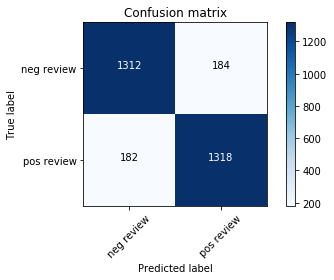

In [14]:
# Build pipeline for model.
pipeline = Pipeline([
    ('cvect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgd',   SGDClassifier()),
])

t0 = time.time()

model = pipeline.fit(X_train, y_train)
model.score(X_test, y_test)
print(f'** SGDClassifier model {env} WordNet ** ')
print('Processing time   : ', (time.time() - t0))
print('Score on train set: ', model.score(X_train, y_train))
print('Score on test set : ', model.score(X_test, y_test))


# Print scores.
y_pred = model.predict(X_test)

# Calculate the confusion matrix.
class_names = ['neg review', 'pos review']
cnf_matrix  = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives    :  %s" % tn)
print("False Positives   :  %s" % fp)
print("False Negatives   :  %s" % fn)
print("True Positives    :  %s" % tp)

# Plot non-normalized confusion matrix.
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')


plt.show()\

### Model with Multinomial Naive Bayes.
#### Naive Bayes classifier for multinomial models.
 

** MultinomialNB model dev WordNet ** 
Processing time   :  1.454658031463623
Score on train set:  0.921173104434907
Score on test set :  0.8481308411214953
True Negatives    :  1341
False Positives   :  155
False Negatives   :  300
True Positives    :  1200
Confusion matrix, without normalization
[[1341  155]
 [ 300 1200]]


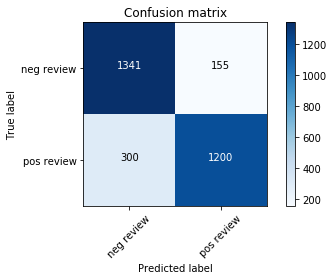

In [15]:
# Build pipeline for model.
pipeline = Pipeline([
    ('cvect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb',    MultinomialNB()),
])

t0 = time.time()

model = pipeline.fit(X_train, y_train)
model.score(X_test, y_test)
print(f'** MultinomialNB model {env} WordNet ** ')
print('Processing time   : ', (time.time() - t0))
print('Score on train set: ', model.score(X_train, y_train))
print('Score on test set : ', model.score(X_test, y_test))

y_pred = model.predict(X_test)

# Calculate the confusion matrix.
class_names = ['neg review', 'pos review']
cnf_matrix  = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives    :  %s" % tn)
print("False Positives   :  %s" % fp)
print("False Negatives   :  %s" % fn)
print("True Positives    :  %s" % tp)

# Plot non-normalized confusion matrix.
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')


plt.show()\

### Model with SentimentIntensityAnalysis with Gaussian Naive Bayes

NLTK Sentiment Analysis.  

In [16]:
# Instantiate model.
sia = SentimentIntensityAnalyzer()

# Initialize a list.
sia_data = []

# Calculate sentiment analysis on X_train.
for review in X_train.tolist():
    sia_data.append(sia.polarity_scores(review)) 
    
# Load sentiment analysis results to a dataframe (X_train).    
X_train_sia_df = pd.DataFrame(sia_data)

# # Take a look.
X_train_sia_df.head()

,compound,neg,neu,pos
0,-0.9296,0.237,0.675,0.088
1,-0.8983,0.139,0.734,0.127
2,0.8337,0.089,0.737,0.174
3,0.8745,0.115,0.737,0.149
4,0.9495,0.050,0.774,0.175


In [17]:
# Initialize a list.
sia_data = []

# Calculate sentiment analysis on X_test.
for review in X_test.tolist():
    sia_data.append(sia.polarity_scores(review)) 
    
# Load sentiment analysis results to a dataframe (X_train).    
X_test_sia_df = pd.DataFrame(sia_data)

# # Take a look.
X_test_sia_df.head()

,compound,neg,neu,pos
0,0.9723,0.094,0.776,0.130
1,0.9331,0.115,0.697,0.188
2,0.2953,0.125,0.748,0.127
3,-0.6960,0.115,0.794,0.092
4,0.9885,0.080,0.713,0.207


** SIA GaussianNB model dev WordNet ** 
Processing time   :  0.003634929656982422
Score on train set:  0.7032904148783977
Score on test set :  0.7049399198931909
True Negatives    :  890
False Positives   :  606
False Negatives   :  278
True Positives    :  1222
Confusion matrix, without normalization
[[ 890  606]
 [ 278 1222]]


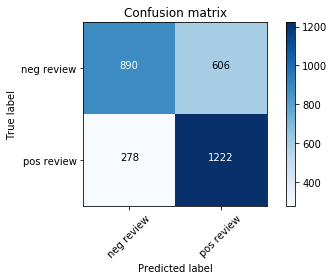

In [18]:
# Model based on sentiment analysis.

# Instantiate model.
model = GaussianNB()

t0 = time.time()

# Fit on training data.
model.fit(X_train_sia_df, y_train)

# Print scores.
print(f'** SIA GaussianNB model {env} WordNet ** ')
print('Processing time   : ', (time.time() - t0))
print('Score on train set: ', model.score(X_train_sia_df, y_train))
print('Score on test set : ', model.score(X_test_sia_df, y_test))

y_pred = model.predict(X_test_sia_df)

# Calculate the confusion matrix.
class_names = ['neg review', 'pos review']
cnf_matrix  = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives    :  %s" % tn)
print("False Positives   :  %s" % fp)
print("False Negatives   :  %s" % fn)
print("True Positives    :  %s" % tp)

# Plot non-normalized confusion matrix.
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')


plt.show()\